In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.set(font_scale=1.2)

df = pd.read_csv('./xeno-canto_ca-nv_index.csv')
df = df.drop(columns = ['Unnamed: 0','country','file_id','file_name','file_url','license','recordist','recordist_url','sonogram_url','remarks'])
df = df.rename(columns={"duration_seconds": "duration", "english_cname": "name"})
df.head()

,duration,name,genus,latitude,location,longitude,species,type,full_name
0,3,Abert's Towhee,Melozone,33.3117,"Cibola National Wildlife Refuge, Cibola, Arizo...",-114.68912,aberti,'seet' call,Abert's Towhee (Melozone aberti)
1,4,Abert's Towhee,Melozone,34.2850,"Bill Williams River NWR, Arizona, United States",-114.06900,aberti,call,Abert's Towhee (Melozone aberti dumeticola)
2,4,Abert's Towhee,Melozone,34.2850,"Bill Williams River NWR, Arizona, United States",-114.06900,aberti,Squeal duet,Abert's Towhee (Melozone aberti dumeticola)
3,5,Abert's Towhee,Melozone,33.1188,"Salton Sea, CA, United States",-115.79450,aberti,interaction duet,Abert's Towhee (Melozone aberti)
4,5,Abert's Towhee,Melozone,36.0628,"Sunset Park, Las Vegas, Nevada, United States",-115.11280,aberti,call,Abert's Towhee (Melozone aberti dumeticola)


Exploring Avian Sounds of the USA

Do you ever wake up 

In [2]:
# We will first check if there are any missing values in our data
# Thankfully it is very clean
df.isnull().sum()

duration     0
name         0
genus        0
latitude     0
location     0
longitude    0
species      0
type         0
full_name    0
dtype: int64

In [3]:
df.dtypes

duration       int64
name          object
genus         object
latitude     float64
location      object
longitude    float64
species       object
type          object
full_name     object
dtype: object

Question 1: What are the differences between a bird call and a bird song?

To a trained, professional ear the beauty of a bird's sound could explain many things; it could be a male's mating call to a potential mate, a song bird's way of establishing their territory, or simply a bark to alert scare off potential predators.  However to laymen like me and most readers, the wide range of sounds just don't seem that different.  Thus we will simplify all the different sounds into two, distinct types: either a call or a song.

In [4]:
# Cleaning up the types into either a call or a song; we sort the numerous types with the best of our ability
def type_clean (type_str):
    call = ['call', 'chatter', 'male', 'squeal', '?', 'barks', 'tick' ,'gargle', 'chip', 'wing']
    song = ['song', 'drumming', 'tapping', 'duet', 'display']

    for i in song:
        if i in type_str.lower():
            return 'song'
    for i in call:
        if i in type_str.lower():
            return 'call'
    return type_str
    
df['type'] = df['type'].apply(type_clean);

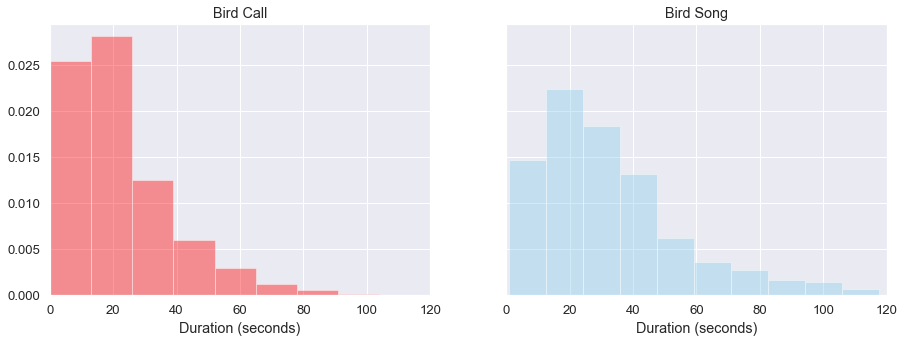

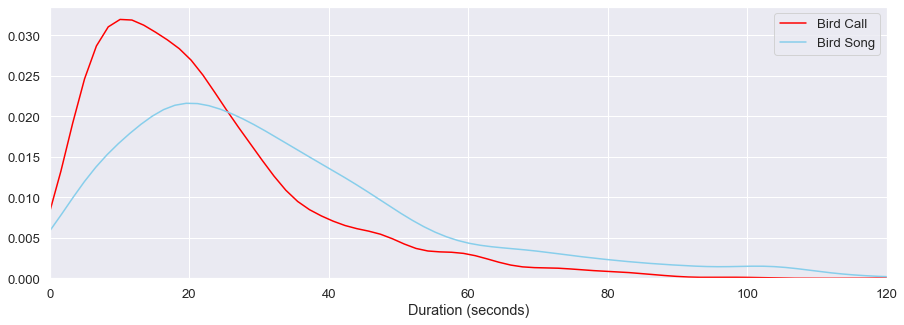

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,sharex=True, figsize = (15,5))
sns.distplot(df['duration'].loc[df['type'] == 'call'], color = 'red', norm_hist = True, bins = 15, kde = False, ax=ax1).set_title('Bird Call')
sns.distplot(df['duration'].loc[df['type'] == 'song'], color = 'skyblue', norm_hist = True, bins = 15, kde = False, ax=ax2).set_title('Bird Song')
plt.xlim(0, 120)
ax1.set_xlabel("Duration (seconds)")
ax2.set_xlabel("Duration (seconds)")

fig, ax3 = plt.subplots(sharey=True, figsize = (15,5))
sns.distplot(df['duration'].loc[df['type'] == 'call'], color = 'red', norm_hist = True, bins = 15, hist = False, ax=ax3, label = ('Bird Call'))
sns.distplot(df['duration'].loc[df['type'] == 'song'], color = 'skyblue', norm_hist = True, bins = 15, hist = False, ax=ax3, label = ('Bird Song'))
plt.xlim(0, 120)
ax3.set_xlabel("Duration (seconds)")
plt.legend();

Above we have our plots that showcase the difference between a typical bird call and a bird song.  We choose the variable 'Duration' to compare the two different types, as to untrained ears such as ourselves, duration is essentially our best metric for comparing the quality between the vocalizations of two birds.  As seen in the normalized plots above, bird calls are more likely to have a shorter duration while bird songs have a wider variety of durations.

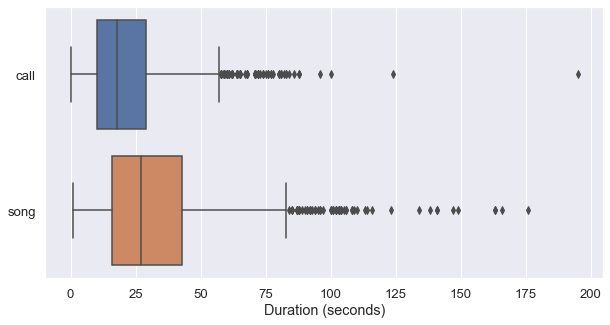

In [6]:
fig, ax1 = plt.subplots(figsize = (10,5))
sns.boxplot(x = 'duration', y = 'type', data = df, ax=ax1);
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("");

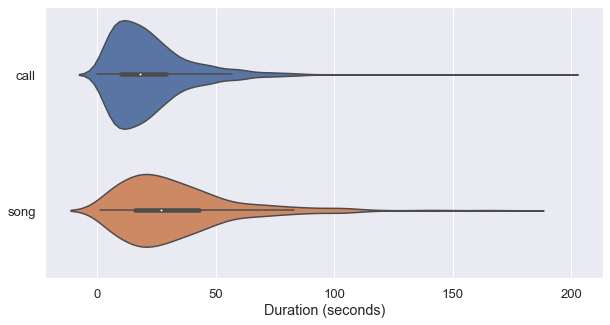

In [7]:
fig, ax1 = plt.subplots(figsize = (10,5))
sns.violinplot(x = 'duration', y = 'type', data = df, ax=ax1);
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("");

These plots showcase the distribution of the durations a bit clearer, so we can better see the average differences between a call and a song.  Most notably however, is the existence of an outlier in the call section.  This single bird has a call that is almost double the second longest call, as well as dwarfing most if not all of the listed songs.

Question 2: Does location have effect on vocalization duration?

Different areas have different properties.  Whether it be the chilling glaciers of the north pole, or the humid jungles in south east Asia, different climates and different environments can lead to variances in species, and thus bird sounds as well.  Our data is all gathered from places in the US, so luckily there won't be any major, drastic differences like in the examples above.

In [8]:
# # Cleaning up the longitudes into a new column, 'region_long'
def long_clean (long_str):
    western = [-125, -110]
    mountain = [-110, -101]
    central = [-101, -89]
    eastern = [-89, -67]
    if long_str < western[1]:
        return 'Western Region'
    elif long_str < mountain[1]:
        return 'Mountain Region'
    elif long_str < central[1]:
        return 'Central Region'
    elif long_str < eastern[1]:
        return 'Eastern Region'
    else:
        return 'Out of North America'

    
df['region_long'] = df['longitude'].apply(long_clean);

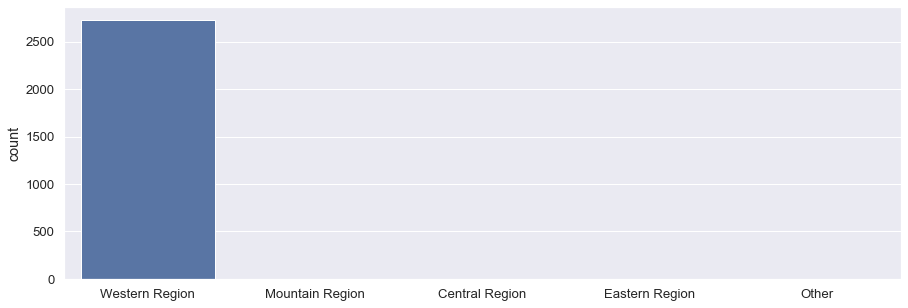

In [9]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=df['region_long'], order=['Western Region', 'Mountain Region', 'Central Region', 'Eastern Region', 'Other'])
ax.set_xlabel("")
plt.show()

We take our data from the 'longitude' column and categorize them based on their regions.  We use the geographical divisions stated by the United States Census Bureau to split them to their respective region: Western USA, Mountain, Central USA, and Eastern USA, as well as an Other region for outliers.  However this ended up being mildly pointless as all the observed bird vocalizations were recorded in the West Coast of the US.

In [10]:
def lat_clean (lat_str):
    division = 35
    if lat_str < 35:
        return "SoCal"
    else:
        return "NorCal"

df['region_lat'] = df['latitude'].apply(lat_clean);

Using our new found knowledge, we can then comfortably further categorize our locations into two simple regions, NorCal and SoCal (for the sake of these plots, we will extend these regions a bit east so that it covers locations in Nevada as well).  While in the same state, Northern California and Southern California are known in particular for having noticeable changes in their climate.  Northern California is more likely to have more temperate climates, while Southern California can have harsh, sunny days; thus there is still potential for differences in  sounds.

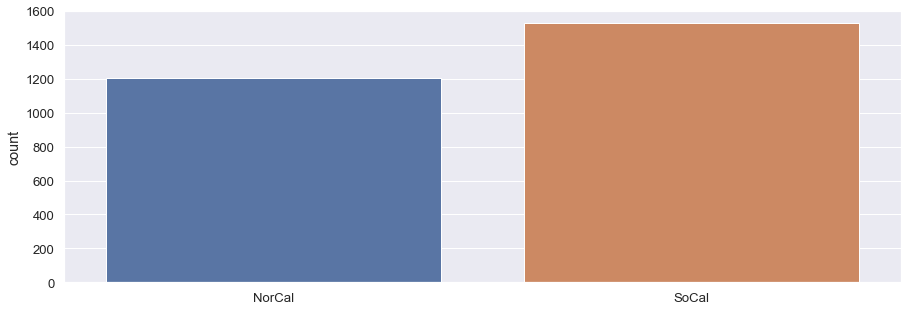

In [23]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=df['region_lat'], order=['NorCal', 'SoCal'])
ax.set_xlabel("")
plt.show()

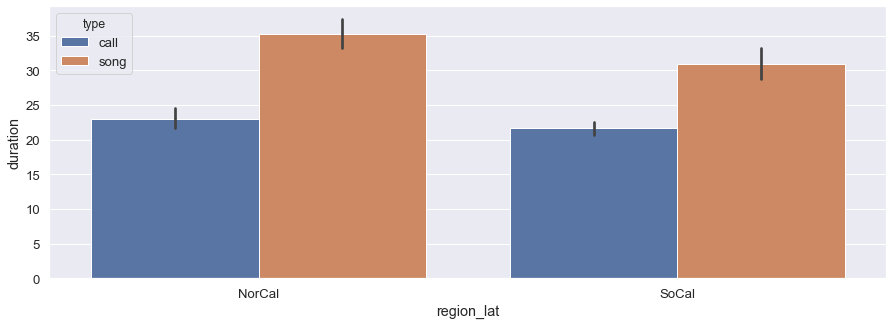

In [12]:
plt.figure(figsize=(15,5))
ax = sns.barplot(y="duration", x="region_lat", hue="type", order=['NorCal', 'SoCal'], data=df)

We can see the counts of the number of different birds in each region in the first plot, while the second plot showcases the average duration of calls and songs from each region.  From the first plot we can tell that SoCal has more birds that we have recorded, but more importantly the second plot contains more information related to our question.  We are able to see that for calls, both regions have similar averages for their durations.  However for bird songs, we can see that the birds in the NorCal region have a much higher average.

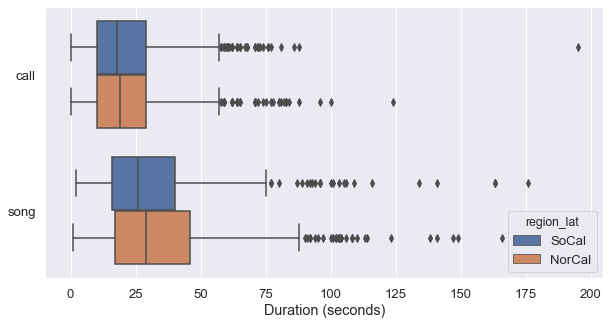

In [13]:
fig, ax1 = plt.subplots(figsize = (10,5))
sns.boxplot(x = 'duration', y = 'type', hue = 'region_lat', data = df, ax=ax1);
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("");

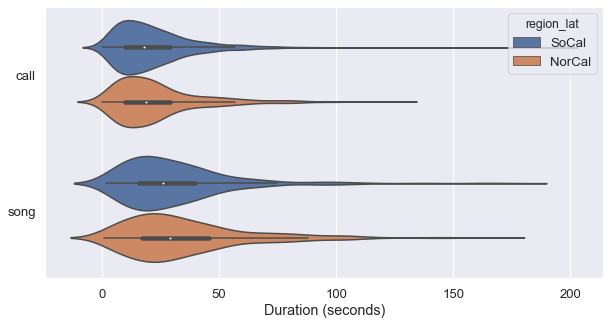

In [14]:
fig, ax1 = plt.subplots(figsize = (10,5))
sns.violinplot(x = 'duration', y = 'type', hue = 'region_lat', data = df, ax=ax1);
ax1.set_xlabel("Duration (seconds)")
ax1.set_ylabel("");

Question 3: When regarding to bird genus and species

In [15]:
# Exploring species based on duration
df_g = df.groupby('species').duration
df_m = df_g.mean().sort_values(ascending = False).reset_index()
df_r = (df_g.max()-df_g.min()).sort_values(ascending = False).reset_index()
df_m = df_m.rename(columns={'duration':'duration_mean'})
df_m = df_m.sort_values(by=['species'])
df_m = df_m.reset_index(drop=True)
df_r = df_r.rename(columns={'duration':'duration_range'})
df_r = df_r.sort_values(by=['species'])
df_r = df_r.reset_index(drop=True)
df_m['duration_range'] = df_r['duration_range']

In [16]:
# Getting a sample of the durations; getting a sample from the largest average
means = df_m.sort_values(by=['duration_mean'], ascending = False)[:5]
means

,species,duration_mean,duration_range
35,grammacus,62.566667,172
49,migratorius,55.533333,105
6,atrogularis,52.800000,189
12,breweri,51.933333,103
65,polyglottos,51.800000,105


Text(0, 0.5, 'Duration (seconds)')

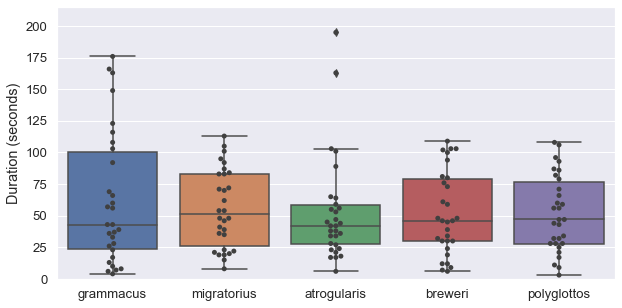

In [17]:
# Showcasing the ranges of the durations for each species
fig, ax1 = plt.subplots(figsize = (10,5))
ax1 = sns.boxplot(x=df['species'].where(df['species'].isin(means['species'])), y=df['duration'], order = means['species'])
ax1 = sns.swarmplot(x=df['species'].where(df['species'].isin(means['species'])), y=df['duration'], color=".25", order = means['species'])
plt.ylim(0, 215)

ax1.set_xlabel("")
ax1.set_ylabel("Duration (seconds)")


Text(0, 0.5, '')

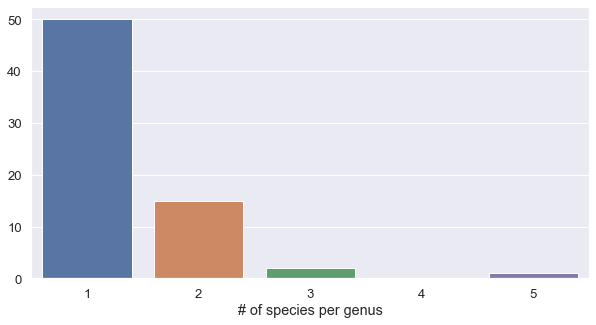

In [18]:
# Look at the number of species per genus
species_count = []
for genus in df['genus'].value_counts().index.tolist():
    species_count.append(df['species'].loc[df['genus'] == genus].value_counts().shape[0])

fig, ax1 = plt.subplots(figsize = (10,5))
ax1 = sns.countplot(species_count, order = [1, 2, 3, 4, 5])
ax1.set_xlabel("# of species per genus")
ax1.set_ylabel("")


Text(0, 0.5, 'Duration (seconds)')

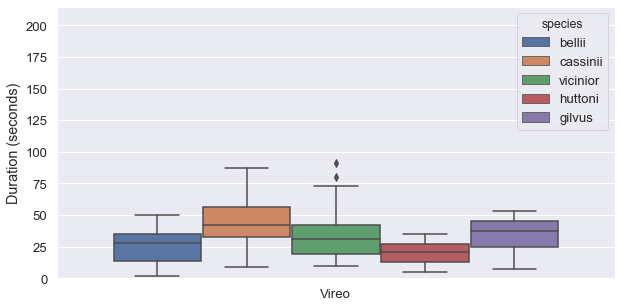

In [19]:
# Showcasing the diferent durations of species in a genus
fig, ax1 = plt.subplots(figsize = (10,5))
ax1 = sns.boxplot(x=df['genus'].where(df['genus'] == 'Vireo'), y=df['duration'], hue=df['species'].loc[df['genus'] == 'Vireo'])
plt.ylim(0, 215)
ax1.set_xlabel("")
ax1.set_ylabel("Duration (seconds)")


Text(0, 0.5, 'Duration (seconds)')

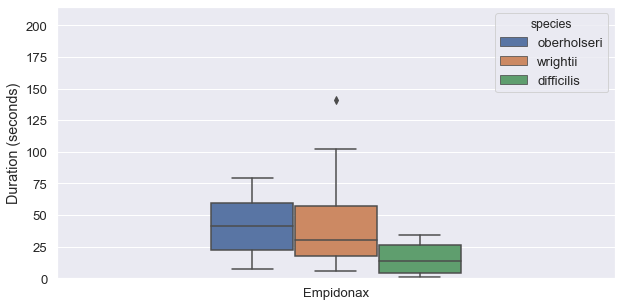

In [20]:
##### Showcasing #2
fig, ax1 = plt.subplots(figsize = (10,5))
ax1 = sns.boxplot(x=df['genus'].where(df['genus'] == 'Empidonax'), y=df['duration'], hue=df['species'].loc[df['genus'] == 'Empidonax'], width = 0.45)
plt.ylim(0, 215)
ax1.set_xlabel("")
ax1.set_ylabel("Duration (seconds)")


Text(0, 0.5, 'Duration (seconds)')

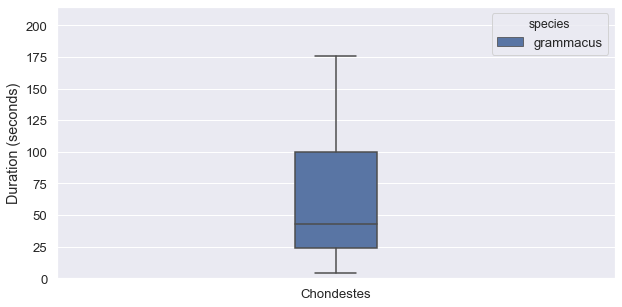

In [21]:
# Showcasing #3
fig, ax1 = plt.subplots(figsize = (10,5))
ax1 = sns.boxplot(x=df['genus'].where(df['genus'] == 'Chondestes'), y=df['duration'], hue=df['species'].loc[df['genus'] == 'Chondestes'], width = 0.15)
plt.ylim(0, 215)
ax1.set_xlabel("")
ax1.set_ylabel("Duration (seconds)")


In [22]:
X = df.drop(columns = ['duration'])
y = df['duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state = 13)

lm_model = LinearRegression(normalize = True)
lm_model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Phainopepla'

In [ ]:
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))